In [29]:
import os

from astropy.io import fits

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, progress
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn, Tensor
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, Dataset, RandomSampler, random_split

import torchmetrics

import torchvision
import torchvision.transforms.v2 as T

In [2]:
torch.manual_seed(123)
np.random.seed(123)

In [3]:
label_df = pd.read_csv("train_info.csv").drop("Unnamed: 0", axis=1)
label_df.head()

,run,n,m1,r1,m2,r2,m3,r3,m4,r4
0,0.0,3.0,0.001738,17.433073,0.004807,56.217795,0.001016,66.676827,0.000000,0.000000
1,1.0,4.0,0.000359,64.147071,0.000192,100.943570,0.000016,118.540489,0.000497,134.070028
2,2.0,3.0,0.000639,54.386533,0.000672,92.352140,0.002246,152.530577,0.000000,0.000000
3,3.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4.0,4.0,0.000053,24.550451,0.000327,35.877340,0.000114,40.213780,0.000283,122.145050


In [4]:
data_names = os.listdir("Full_Train_Data")
data_names = np.array([x for x in data_names if ".fits" in x])
data_names[:5]

array(['planet811_00218_1250.fits', 'planet6_00704_1250.fits',
       'planet837_00018_1250.fits', 'planet70_00322_1250.fits',
       'planet14_00528_1250.fits'], dtype='<U25')

In [5]:
run_nums = np.array([int(x.split("planet")[1].split("_")[0]) for x in data_names])
order = np.argsort(run_nums)
run_nums = run_nums[order]
data_names = data_names[order]

In [6]:
runs = label_df.run.to_numpy()
Ns = label_df.n.to_numpy()

In [7]:
labels = {}
nums = {}
for (name, run) in zip(data_names, run_nums):
    label = Ns[np.where(runs == run)][0]
    nums[name] = int(label)
    labels[name] = int(label > 0)

In [49]:
data = {}
for name in data_names:
    data[name] = fits.open(f"Full_Train_Data/{name}")[0].data.squeeze()[0]
    # normalize
    data[name] -= np.min(data[name])
    data[name] /= np.max(data[name])

In [52]:
xy_dim = data[data_names[0]].shape[1]
X = np.empty((len(data_names), 3, xy_dim, xy_dim))
y = np.empty((len(data_names), 1))

In [53]:
# load images and labels
for i, name in enumerate(data_names):
    X[i, :, :] = data[name]
    y[i, 0] = labels[name]

In [54]:
X = X.astype(np.float32)
y = y.astype(np.float32)

In [55]:
test_split = 0.2
val_split = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_split)

In [56]:
class DiskDataset(Dataset):

    """Data loader"""

    def __init__(
        self,
        X: np.ndarray,
        y: np.ndarray,
        transform: list = None,
        accelerator_name: str = "mps",
        num_workers: int = 13,
    ) -> None:

        self.X = X
        self.y = y
        self.transform = transform
        self.num_workers = num_workers
        
        if accelerator_name == "mps":
            self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        elif accelerator_name == "cuda:0":
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx) -> torch.Tensor:
        x_, y_ = self.X[idx], self.y[idx]

        x_, y_ = torch.from_numpy(x_),\
                torch.from_numpy(y_)

        if self.transform:
            x_ = self.transform(x_)
        return x_.to(self.device), y_.to(self.device)

In [57]:
input_size = 380
transform = T.Compose([
                        T.Resize((input_size, input_size), antialias=True),
                        T.Normalize(mean=[0.5], std=[0.5]),
])

train_transform = T.Compose(
    [
        T.AugMix(),
        transform,
    ]
)

In [58]:
train_data = DiskDataset(X_train, y_train, transform=train_transform)
val_data = DiskDataset(X_val, y_val, transform=transform)
test_data = DiskDataset(X_test, y_test, transform=transform)

In [59]:
batch_size = 32

# make the loader
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)#, num_workers=13)
val_loader = DataLoader(val_data, batch_size=batch_size)#, num_workers=13)

In [60]:
class CustomEfficientNetV2(pl.LightningModule):
    def __init__(self,
                 num_channels: int = 1,
                 num_outputs: int = 1,
                 lr: float = 1e-4,
                 xy_dim: int = 380,
                ):
        super().__init__()
        self.save_hyperparameters()

        # Load EfficientNetV2 model
        self.model = torchvision.models.efficientnet_v2_s()

        # Modify the first convolutional layer if input channels are different from 3
        if num_channels != 3:
            self.model.features[0][0] = nn.Conv2d(num_channels,
                                                  self.model.features[0][0].out_channels,
                                                  kernel_size=self.model.features[0][0].kernel_size,
                                                  stride=self.model.features[0][0].stride,
                                                  padding=self.model.features[0][0].padding,
                                                  bias=False,
                                                 )

        # Modify the final fully connected layer
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_outputs)

        self.criterion = nn.BCEWithLogitsLoss()

        # Initialize containers to store outputs
        self.validation_outputs = []
        self.test_outputs = []

        self.example_input_array = torch.randn((1, num_channels, xy_dim, xy_dim)).float()

    def forward(self, x):
        return self.model(x)

    def _process_batch(self, batch, when: str = "train"):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log(f"{when}_loss", loss)
        if when != "train":
            return {f"{when}_loss": loss, "y_hat": y_hat, "y": y}
        return loss

    def training_step(self, batch, batch_idx):
        return self._process_batch(batch, when="train")

    def validation_step(self, batch, batch_idx):
        outputs = self._process_batch(batch, when="val")
        self.validation_outputs.append(outputs)
        return outputs

    def test_step(self, batch, batch_idx):
        outputs = self._process_batch(batch, when="test")
        self.test_outputs.append(outputs)
        return outputs

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                               )

    def _roc_epoch_end(self, outputs, when: str = "val"):
        """Logs AUC during validation/testing"""
        y_hat = torch.cat([x["y_hat"] for x in outputs]).detach().cpu().numpy()
        y = torch.cat([x["y"] for x in outputs]).detach().cpu().numpy()
        auc = self.calculate_auc(y_hat, y)
        self.log(f"{when}_auc", auc)

    def on_validation_epoch_end(self,):
        self._roc_epoch_end(self.validation_outputs, when="val")
        self.validation_outputs.clear()

    def on_test_epoch_end(self,):
        self._roc_epoch_end(self.test_outputs, when="test")
        self.test_outputs.clear()

    def calculate_auc(self, y_hat, y):
        # Apply sigmoid to predictions if using BCEWithLogitsLoss
        y_hat = torch.sigmoid(torch.tensor(y_hat).float()).numpy()
        auc = roc_auc_score(y, y_hat)
        return np.float32(auc)

In [61]:
model = CustomEfficientNetV2(xy_dim = input_size)

In [62]:
accelerator_name = "mps"

if accelerator_name == "mps":
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
elif accelerator_name == "cuda:0":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [63]:
devices = 1
accelerator = "gpu" if devices == 1 else "cpu"

In [64]:
device

device(type='mps')

In [65]:
#### This is artificially small for the purposes of speed
num_epochs = 30
# make the trainer
trainer = pl.Trainer(
    devices=devices,
    accelerator=accelerator,
    max_epochs=num_epochs,
    log_every_n_steps=1,
    callbacks=[
        LearningRateMonitor("epoch"),
        progress.TQDMProgressBar(refresh_rate=1),
        EarlyStopping(
            monitor="val_auc",
            min_delta=0,
            patience=20,
            verbose=False,
            mode="min",
        ),
    ],
)
trainer.logger._log_graph = True
trainer.logger._default_hp_metric = None



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [66]:
model = model.to(device)

# fit the model
trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)


  | Name      | Type              | Params | Mode  | In sizes         | Out sizes
---------------------------------------------------------------------------------------
0 | model     | EfficientNet      | 20.2 M | train | [1, 3, 380, 380] | [1, 1]   
1 | criterion | BCEWithLogitsLoss | 0      | train | ?                | ?        
---------------------------------------------------------------------------------------
20.2 M    Trainable params
0         Non-trainable params
20.2 M    Total params
80.715    Total estimated model params size (MB)
715       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/Users/jamesmitchell-white/Documents/GitHub/DeepLearnHackathon/ExoplanetSearchChallenge/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/jamesmitchell-white/Documents/GitHub/DeepLearnHackathon/ExoplanetSearchChallenge/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

In [67]:
model.eval()
print("Testing model")

Testing model


In [68]:
test_batch_size = 16
test_loader = DataLoader(test_data, batch_size=test_batch_size)

In [69]:
model.to("mps")
results = []

for X_batch in test_loader:
    X_batch = X_batch[0]  # DataLoader returns a tuple
    with torch.no_grad():
        outputs = torch.sigmoid(model(X_batch)).cpu()
    batch_results = outputs.detach().numpy().squeeze()
    results.append(batch_results)

y_pred = np.concatenate(results, axis=0)

In [70]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
accuracy = np.sum([round(y_pred[i]) == y_test[i] for i in range(len(y_test))]) / len(y_test)

print(f"Accuracy of {accuracy:.2}. AUC of {auc}")

Accuracy of 0.91. AUC of 0.908266428783824


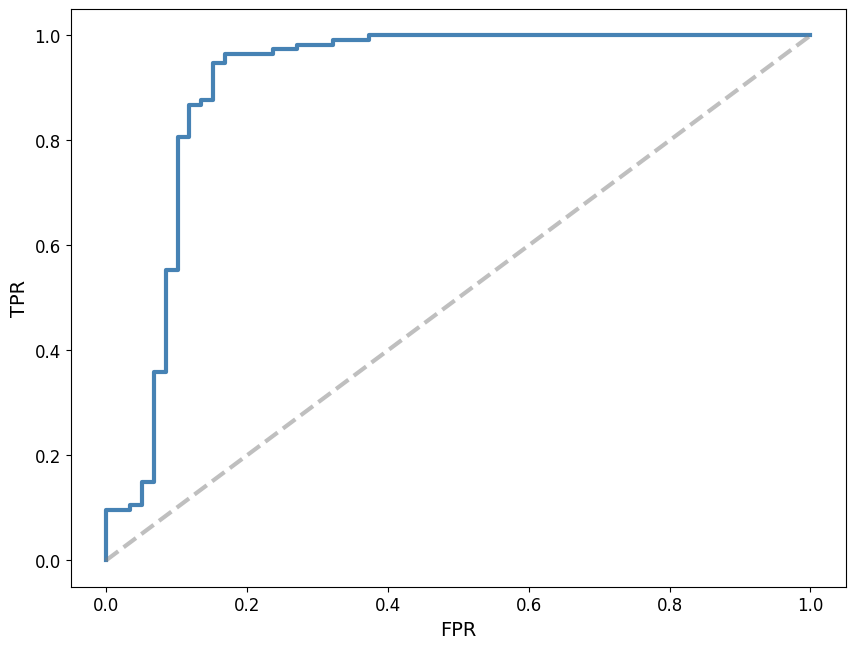

In [71]:
plt.figure(figsize=(10., 7.5))

plt.plot(fpr, tpr, lw=3, c="steelblue")
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100),
         c="gray", ls="--", alpha=0.5, lw=3,
         )

plt.xlabel("FPR", fontsize=14)
plt.ylabel("TPR", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

| Epochs | AUC |
|--------|-----|
| 5      | 0.62|
| 30 (terminated early at 26) | 0.94 |